Install libraries & load data

In [40]:
# Install spacy quietly
!pip install spacy -q

In [41]:
# Download english language model
!python -m spacy download en -q

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [42]:
# Install wordcloud
!pip install wordcloud

1. Import pandas, numpy, spacy, sklearn (tfidf vectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud

In [43]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Reading the corpus and put it in a DataFrame named `corpus`. I print the full description in the first line

In [44]:
corpus = pd.read_csv('C:/Users/ishs4/Desktop/promotheo/sample-data.csv')


In [45]:
print(corpus.shape)
corpus.head()

(500, 2)


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [46]:
print('Description of the first product : ',corpus.loc[0,'description'])

Description of the first product :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br>

`Description is dirty due to HTML elements, punctuation and the not standardization of the words.`

### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Using `str` methods to clean the texts. I save the clean texts into a column named `clean_description`

In [47]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program

4. Tranforming every character into lowercase.

In [48]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  active classic boxers - there's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. the quick-drying, lightweight underwear takes up minimal space in a travel pack. an exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. made of 3.7-oz 100% recycled polyester with moisture-wicking performance. inseam (size m) is 4 1/2". recyclable through the common threads recycling program.<br><br><b>details:</b><ul> <li>"silky capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"inseam (size m) is 4 1/2"""</li></ul><br><br><b>fabric: </b>3.7-oz 100% all-recycled polyester with gladiodor natural odor control for the garment. recyclable through the common threads recycling p

5. Using spacy to tokenize the documents and put the result in a new column named `clean_tokens`.

`Tokenization is a way of separating a piece of text into smaller units called tokens. Tokens can be either words, characters, or subwords.`

In [49]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"(active, classic, boxers, -, there, 's, a, rea..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"(active, sport, boxer, briefs, -, skinning, up..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"(active, sport, briefs, -, these, superbreatha..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","(alpine, guide, pants, -, skin, in, ,, climb, ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","(alpine, wind, jkt, -, on, high, ridges, ,, st..."


6. Removing the stop words and lemmatize `clean_tokens`

- `Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.`
- `Lemmatization is a linguistic term that means grouping together words with the same root or lemma.`

In [50]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ..."


7. Writing all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [51]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin..."


## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

In [52]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(500, 3930)


In [53]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('000', 0), ('03', 1), ('10', 2), ('100', 3), ('1000', 4), ('1021', 5), ('1027', 6), ('103', 7), ('1038', 8), ('1055', 9), ('106', 10), ('1070', 11), ('108', 12), ('109', 13), ('1096', 14), ('11', 15), ('110', 16), ('112', 17), ('1125', 18), ('1128', 19), ('1139', 20), ('115', 21), ('116', 22), ('1171', 23), ('118', 24), ('1188', 25), ('11c', 26), ('12', 27), ('1200', 28), ('121', 29), ('1234', 30), ('124', 31), ('125', 32), ('126', 33), ('127', 34), ('129', 35), ('1298', 36), ('12d', 37), ('13', 38), ('130', 39), ('132', 40), ('1324', 41), ('1327', 42), ('133', 43), ('1341', 44), ('135', 45), ('138', 46), ('14', 47), ('141', 48), ('144', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [73]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
                    columns=vectorizer.get_feature_names_out(), 
                    index=["item_{}".format(x) for x in range(corpus.shape[0])])

X_df.head()


,000,03,10,100,1000,1021,1027,103,1038,1055,...,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zones
item_0,0.0,0.0,0.000000,0.072986,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
item_1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
item_2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
item_3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.049367,0.199477,0.097807,0.0,0.0,0.0,0.0
item_4,0.0,0.0,0.047788,0.047148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.148537,0.000000,0.000000,0.0,0.0,0.0,0.0


In [55]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ...",0
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin...",0


,000,03,10,100,1000,1021,1027,103,1038,1055,...,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zones,cluster_id
item_0,0.0,0.0,0.000000,0.072986,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049367,0.199477,0.097807,0.0,0.0,0.0,0.0,0
item_4,0.0,0.0,0.047788,0.047148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.148537,0.000000,0.000000,0.0,0.0,0.0,0.0,0


4. Display number of documents in each cluster

In [56]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

cluster_id
 0    477
 1      8
-1      6
 3      5
 2      4
Name: count, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [57]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  0  :
----
s/s a/c shirt - not even stifling great basin heat can overwhelm the born-to-chill a/c shirt. a/c fabric is made of 100% organic cotton and has a crepe-like crinkle that allows the fabric to hover over skin, inviting the slightest breeze. subtle yarn-dyed plaids are soft and soothing. shaping seams give the shirt a contoured fit without sacrificing airflow; the full-length button placket with feminine binding and coconut buttons provide layering options. recyclable through the common threads recycling program.<br><br><b>details:</b><ul> <li>"fabric is light, airy and easy to care for"</li> <li>princess seaming for shaping</li> <li>delicate collar</li> <li>full-length button placket with feminine binding and coconut buttons</li></ul><br><br><b>fabric: </b>3.2-oz 100% organic cotton yarn-dyed plain weave. recyclable through the common threads recycling program<br><br><b>weight: </b>(129 g 4.5 oz)<br><br>made in thailand.

merino 2 t-shirt - our most versatile merino ba

6. Print the 5 most frequent words in the 5 first clusters

In [58]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  0
li         0.202634
br         0.173614
oz         0.051329
pocket     0.049889
organic    0.048714
dtype: float64
-----------
CLUSTER  1
photo      0.325962
poster     0.208365
outside    0.196524
br         0.132666
print      0.120636
dtype: float64
-----------
CLUSTER  -1
li         0.207973
br         0.169180
cotton     0.092334
organic    0.092334
big        0.087633
dtype: float64
-----------
CLUSTER  3
insole        0.269740
support       0.202451
midsole       0.185557
filtration    0.174371
leather       0.169905
dtype: float64
-----------
CLUSTER  2
buckle      0.231926
aluminum    0.202539
web         0.197864
br          0.195763
belt        0.182184
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  0


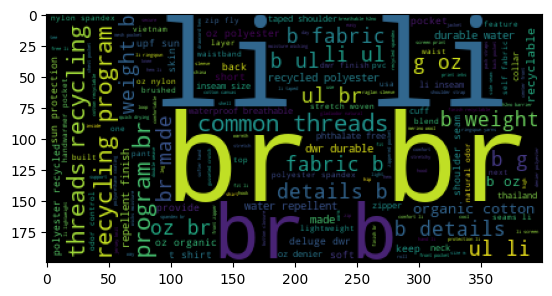

-----------
CLUSTER  1


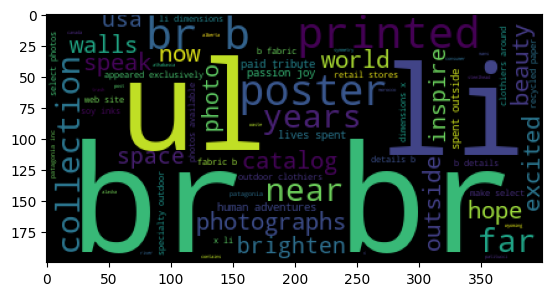

-----------
CLUSTER  -1


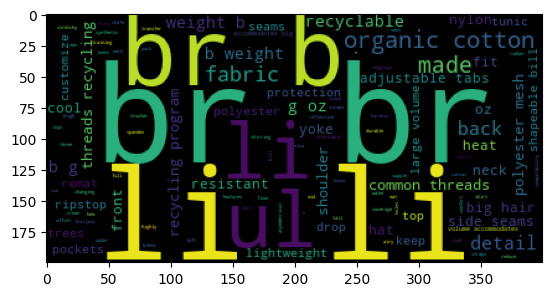

-----------
CLUSTER  3


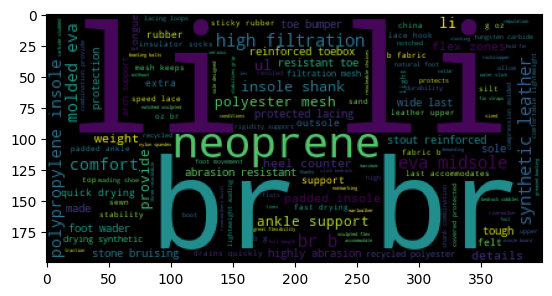

-----------
CLUSTER  2


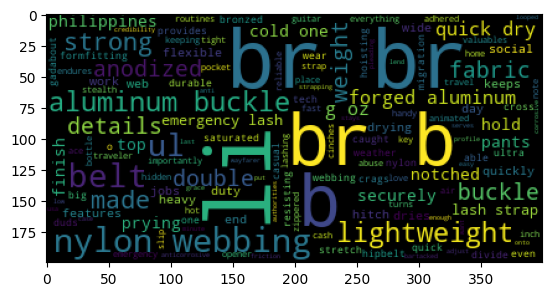

-----------


In [59]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - Recommender system <a class="anchor" id="chapter3"></a>

Now, we use the clusters created from part 1 to build a recommender system. 
The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we consider that products belonging to the same cluster are similar.

In [60]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ...",0
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin...",0


1. We Create a function named `find_similar_items` that return the 5 items ids belonging to the same cluster as the product `item_id` which is passed in arguments

In [61]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

2. Using python's `input()` function to allow the user to choose a product and submit some suggestions of similar items

In [62]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [64]:
product_id = int(input("What product would you like to buy ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print(f"{bcolors.OKBLUE}Product found in database, description below :")
    print(item_desc)
    print()
    
    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')


Product found in database, description below :
active classic boxers - there's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. the quick-drying, lightweight underwear takes up minimal space in a travel pack. an exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. made of 3.7-oz 100% recycled polyester with moisture-wicking performance. inseam (size m) is 4 1/2". recyclable through the common threads recycling program.<br><br><b>details:</b><ul> <li>"silky capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"inseam (size m) is 4 1/2"""</li></ul><br><br><b>fabric: </b>3.7-oz 100% all-recycled polyester with gladiodor natural odor control for the garment. recyclable through the common threads recycling pro

## Part 4 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example Sport and Politics.

1. Using TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [65]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.380079,-0.040819,0.177221,0.055872,-0.119984,-0.033741,-0.049264,-0.003907,-0.137188,0.033623,-0.042927,0.015436,active classic boxers - there's a reason why o...
1,0.379993,-0.064546,0.103431,0.078026,-0.027909,0.069934,-0.086601,-0.029310,-0.135715,-0.047997,0.011278,0.134993,active sport boxer briefs - skinning up glory ...
2,0.370185,-0.081347,0.099791,0.017871,-0.027160,0.117570,-0.015972,0.042880,-0.073906,-0.024392,-0.011833,0.185865,active sport briefs - these superbreathable no...
3,0.463639,-0.247920,-0.122706,-0.128018,0.036710,-0.046121,-0.030512,-0.053376,-0.095121,-0.096809,0.100429,0.030880,"alpine guide pants - skin in, climb ice, switc..."
4,0.440263,-0.263903,-0.053557,-0.232022,-0.045532,-0.052001,0.014374,0.052625,-0.003023,-0.119793,0.168201,-0.034172,"alpine wind jkt - on high ridges, steep ice an..."


Contrary to clustering, LSA allows to map each document to a mixing of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Creation of a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document

In [66]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

C:\Users\ishs4\AppData\Local\Temp\ipykernel_5952\3040406549.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'topic_0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.380079,-0.040819,0.177221,0.055872,-0.119984,-0.033741,-0.049264,-0.003907,-0.137188,0.033623,-0.042927,0.015436,active classic boxers - there's a reason why o...,topic_0
1,0.379993,-0.064546,0.103431,0.078026,-0.027909,0.069934,-0.086601,-0.029310,-0.135715,-0.047997,0.011278,0.134993,active sport boxer briefs - skinning up glory ...,topic_0
2,0.370185,-0.081347,0.099791,0.017871,-0.027160,0.117570,-0.015972,0.042880,-0.073906,-0.024392,-0.011833,0.185865,active sport briefs - these superbreathable no...,topic_0
3,0.463639,-0.247920,-0.122706,-0.128018,0.036710,-0.046121,-0.030512,-0.053376,-0.095121,-0.096809,0.100429,0.030880,"alpine guide pants - skin in, climb ice, switc...",topic_0
4,0.440263,-0.263903,-0.053557,-0.232022,-0.045532,-0.052001,0.014374,0.052625,-0.003023,-0.119793,0.168201,-0.034172,"alpine wind jkt - on high ridges, steep ice an...",topic_0


3. Couting each main topic in the corpus 

In [67]:
topic_encoded_df['main_topic'].value_counts()

main_topic
topic_0     376
topic_1      40
topic_2      19
topic_5      18
topic_7      17
topic_11     11
topic_9       8
topic_4       8
topic_8       3
Name: count, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Using the attribute `components_` of the SVD model to print the 5 most important words in each topic

In [69]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,000,03,10,100,1000,1021,1027,103,1038,1055,...,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zones
topic_0,0.001985,0.000374,0.035283,0.094318,0.000350,0.000197,0.000267,0.008630,0.000309,0.000191,...,0.000434,0.058804,0.000575,0.056878,0.049328,0.005117,0.001141,0.005155,0.002809,0.002931
topic_1,0.000340,0.000777,0.007100,0.052641,0.000536,0.000486,0.000311,0.021171,0.000626,0.000303,...,0.000800,0.052288,0.001106,0.096732,0.078978,0.010357,0.002657,0.010968,0.004543,0.008141
topic_2,0.001549,0.000854,0.036682,0.021371,0.000600,0.000433,0.000098,0.000869,0.000720,0.000129,...,0.000811,0.055314,0.000479,0.053842,0.067106,0.008971,0.002302,0.009212,0.003986,0.007372
topic_3,0.003823,0.001399,0.081523,0.071388,0.001091,0.000745,0.000015,0.005888,0.001270,0.000139,...,0.000685,0.078612,0.001071,0.116821,0.060018,0.013352,0.005007,0.017833,0.004632,0.014841
topic_4,0.002051,0.000429,0.012090,0.064210,0.000513,0.000065,0.000013,0.002357,0.000303,0.000272,...,0.000296,0.024929,0.000085,0.015187,0.007162,0.003836,0.000687,0.002466,0.012472,0.009501


In [70]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['li', 'br', 'oz', 'organic', 'pocket']

-------------------------

TOPIC : topic_1
['organic', 'shirt', 'cotton', 'print', 'ringspun']

-------------------------

TOPIC : topic_2
['merino', 'odor', 'wool', 'pocket', 'control']

-------------------------

TOPIC : topic_3
['inseam', 'organic', 'cotton', 'button', 'waterproof']

-------------------------

TOPIC : topic_4
['merino', 'wool', 'wash', 'sun', 'capilene']

-------------------------

TOPIC : topic_5
['82', 'spandex', 'nylon', 'coverage', '18']

-------------------------

TOPIC : topic_6
['sun', 'upf', 'cotton', 'organic', 'inseam']

-------------------------

TOPIC : topic_7
['strap', 'waterproof', 'barrier', 'deni', 'mesh']

-------------------------

TOPIC : topic_8
['sun', 'protection', 'upf', '30', 'collar']

-------------------------

TOPIC : topic_9
['photo', 'poster', 'outside', 'waterproof', 'spandex']

-------------------------

TOPIC : topic_10
['fleece', 'photo', 'waterproof', 'poster', 'wind']

-----

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [71]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.380079,-0.040819,0.177221,0.055872,-0.119984,-0.033741,-0.049264,-0.003907,-0.137188,0.033623,-0.042927,0.015436,active classic boxers - there's a reason why o...,topic_0
1,0.379993,-0.064546,0.103431,0.078026,-0.027909,0.069934,-0.086601,-0.029310,-0.135715,-0.047997,0.011278,0.134993,active sport boxer briefs - skinning up glory ...,topic_0
2,0.370185,-0.081347,0.099791,0.017871,-0.027160,0.117570,-0.015972,0.042880,-0.073906,-0.024392,-0.011833,0.185865,active sport briefs - these superbreathable no...,topic_0
3,0.463639,-0.247920,-0.122706,-0.128018,0.036710,-0.046121,-0.030512,-0.053376,-0.095121,-0.096809,0.100429,0.030880,"alpine guide pants - skin in, climb ice, switc...",topic_0
4,0.440263,-0.263903,-0.053557,-0.232022,-0.045532,-0.052001,0.014374,0.052625,-0.003023,-0.119793,0.168201,-0.034172,"alpine wind jkt - on high ridges, steep ice an...",topic_0


-------------------------

TOPIC  topic_0


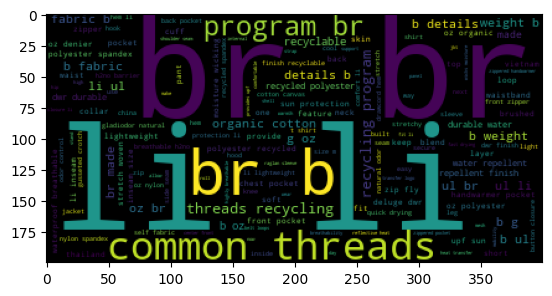


-------------------------

TOPIC  topic_1


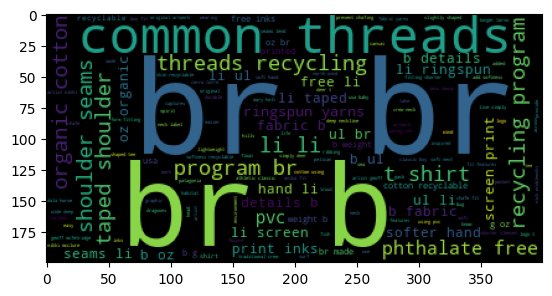


-------------------------

TOPIC  topic_2


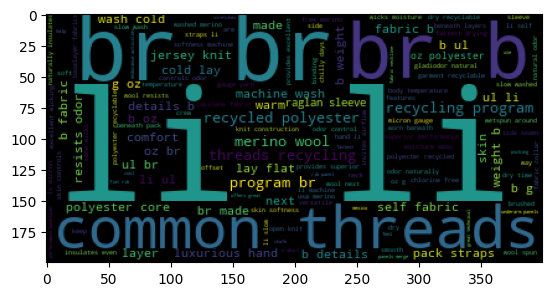


-------------------------

TOPIC  topic_3
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_4


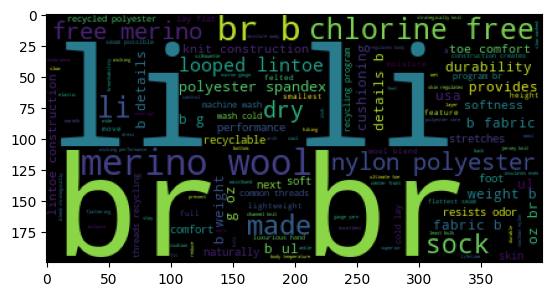


-------------------------

TOPIC  topic_5


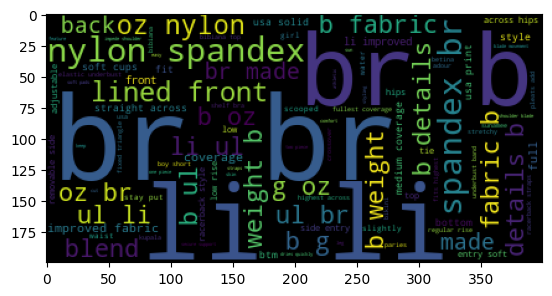


-------------------------

TOPIC  topic_6
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_7


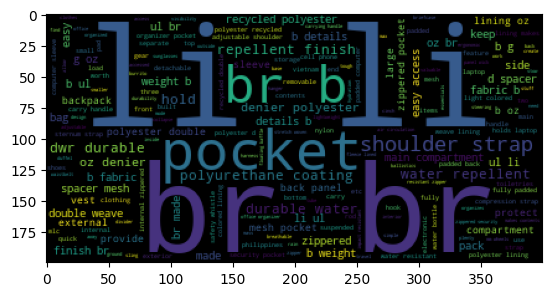


-------------------------

TOPIC  topic_8


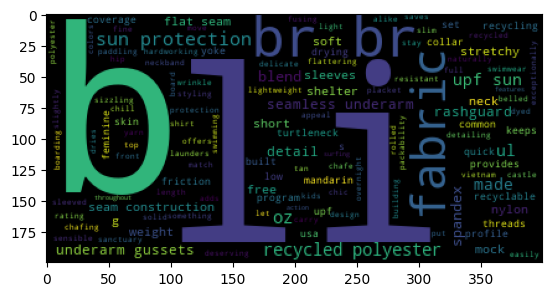


-------------------------

TOPIC  topic_9


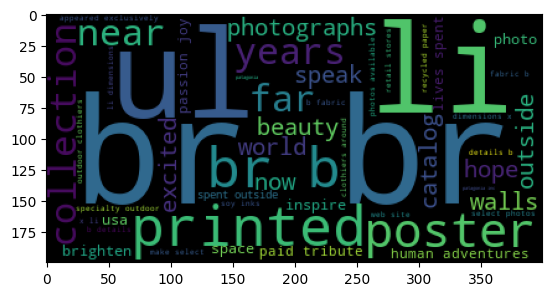


-------------------------

TOPIC  topic_10
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_11


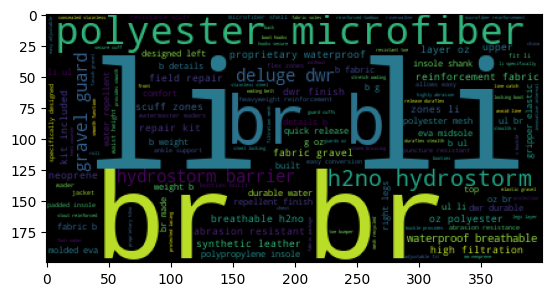

In [72]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()